<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/click-sequence-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Sequences of Clicks on the Server

Make sure to run this from top to bottom to export model, otherwise names of layers cause tf.js to bail out

In [1]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [7]:
import pandas as pd
print(pd.__version__)

0.24.2


In [8]:
import numpy as np
print(np.__version__)

1.16.5


In [0]:
# local
# URL = '../data/click-sequence.json'

# remote
URL = 'https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master//data/click-sequence.json'


df = pd.read_json(URL, typ='series')

In [10]:
len(df)

51

In [11]:
df.head()

0                                                   []
1                   [train-model, save-model-to-local]
2                      [load-local-model, train-model]
3    [load-local-model, train-model, toggle-visor, ...
4    [train-model, show-eval, train-model, save-mod...
dtype: object

In [12]:
type(df[0])

list

In [13]:
df[0], df[1]

([], ['train-model', 'save-model-to-local'])

In [14]:
all_buttons = set()
for seq in df:
  for button in seq:
    all_buttons.add(button)

all_buttons.add('<START>')
all_buttons.add('<EMPTY>')

all_buttons = list(all_buttons)

all_buttons

['download-model',
 'load-remote-model',
 'toggle-visor',
 'show-model',
 'upload-model',
 'reset-data',
 'save-model-to-local',
 '<START>',
 '<EMPTY>',
 'toggle-prediction',
 'load-local-model',
 'reset-model',
 'show-eval',
 'train-model']

In [15]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_buttons)
encoder.classes_

array(['<EMPTY>', '<START>', 'download-model', 'load-local-model',
       'load-remote-model', 'reset-data', 'reset-model',
       'save-model-to-local', 'show-eval', 'show-model',
       'toggle-prediction', 'toggle-visor', 'train-model', 'upload-model'],
      dtype='<U19')

In [16]:
transfomed_labels = [encoder.transform(seq) for seq in df if len(seq) != 0]
transfomed_labels

[array([12,  7]),
 array([ 3, 12]),
 array([ 3, 12, 11, 11, 12,  6, 12]),
 array([12,  8, 12,  7]),
 array([ 3, 12,  8,  7,  2, 11, 10]),
 array([12,  9, 11,  8, 11, 11,  7, 10]),
 array([12, 11,  7, 11,  8,  5, 12, 11,  7,  8,  8,  8]),
 array([12, 12,  7,  8, 11, 10,  7,  2]),
 array([13, 13, 13, 13, 10]),
 array([ 5, 12, 10,  8, 10, 10, 10, 11, 10, 10,  6, 12, 11,  7, 12,  7,  8,
         8, 10, 11, 10,  6, 12, 11,  7,  8,  8, 10, 10]),
 array([12,  7, 11,  2, 10, 13, 13, 11,  8,  8]),
 array([13, 13, 10,  5, 10]),
 array([12, 10, 11]),
 array([12]),
 array([12,  8,  6, 12, 11, 11, 11,  8,  8, 12,  6, 12,  7,  8,  8,  5,  6,
        12, 11,  8,  8, 11,  6, 12, 11,  7, 11, 10, 10, 12, 11, 11, 10, 10,
        12, 11,  7,  8,  8, 11, 10]),
 array([12]),
 array([12]),
 array([12,  3, 10, 11, 10]),
 array([10,  3,  3, 10, 10, 10, 12, 11, 11,  8,  8, 10, 11, 12]),
 array([12, 11]),
 array([12,  8, 11, 11, 10, 10, 11, 11]),
 array([12]),
 array([12,  8]),
 array([11, 11, 11,  8]),
 array([

## pre-process data into chunks

In [0]:
empty = encoder.transform(['<EMPTY>'])
start = encoder.transform(['<START>'])
chunk_size = 5

In [0]:
# [ 1, 11,  7, 11,  6] => [[[0, 0, 0, 0, 1], 11], [[0, 0, 0, 1, 11], 7], [[0, 0, 1, 11, 7], 11], [[0, 1, 11, 7, 11], 6]]

def create_sequences(seq, chunk_size, empty, start):
  # all sequences implicitly start
  seq = np.append(start, seq)
  # if sequence is too short, we pad it to minimum size at the beginning
  seq = np.append(np.full(chunk_size - 1, empty), seq)
  
  seqs = np.array([])
  for index in range(chunk_size, len(seq)):
    y = seq[index]
    x = seq[index-chunk_size : index]
    seqs = np.append(seqs, [x, y])
  return seqs

In [19]:

# seq = transfomed_labels[0]
# seq = transfomed_labels[9]
seq = transfomed_labels[3]
seq

array([12,  8, 12,  7])

In [20]:
create_sequences(seq, chunk_size, empty, start)

array([array([0, 0, 0, 0, 1]), 12, array([ 0,  0,  0,  1, 12]), 8,
       array([ 0,  0,  1, 12,  8]), 12, array([ 0,  1, 12,  8, 12]), 7],
      dtype=object)

In [21]:
seqs = np.array([])
for seq in transfomed_labels:
  seqs = np.append(seqs, create_sequences(seq, chunk_size, empty, start))
seqs = seqs.reshape(-1, 2)
seqs.shape

(279, 2)

In [22]:
X = seqs[:, 0]
# X = X.reshape(-1, chunk_size)
X = np.vstack(X).astype('int32')
X.dtype, X.shape

(dtype('int32'), (279, 5))

In [23]:
y = seqs[:, 1].astype('int32')
y.dtype, y.shape, y

(dtype('int32'),
 (279,),
 array([12,  7,  3, 12,  3, 12, 11, 11, 12,  6, 12, 12,  8, 12,  7,  3, 12,
         8,  7,  2, 11, 10, 12,  9, 11,  8, 11, 11,  7, 10, 12, 11,  7, 11,
         8,  5, 12, 11,  7,  8,  8,  8, 12, 12,  7,  8, 11, 10,  7,  2, 13,
        13, 13, 13, 10,  5, 12, 10,  8, 10, 10, 10, 11, 10, 10,  6, 12, 11,
         7, 12,  7,  8,  8, 10, 11, 10,  6, 12, 11,  7,  8,  8, 10, 10, 12,
         7, 11,  2, 10, 13, 13, 11,  8,  8, 13, 13, 10,  5, 10, 12, 10, 11,
        12, 12,  8,  6, 12, 11, 11, 11,  8,  8, 12,  6, 12,  7,  8,  8,  5,
         6, 12, 11,  8,  8, 11,  6, 12, 11,  7, 11, 10, 10, 12, 11, 11, 10,
        10, 12, 11,  7,  8,  8, 11, 10, 12, 12, 12,  3, 10, 11, 10, 10,  3,
         3, 10, 10, 10, 12, 11, 11,  8,  8, 10, 11, 12, 12, 11, 12,  8, 11,
        11, 10, 10, 11, 11, 12, 12,  8, 11, 11, 11,  8, 12,  8, 11, 11, 12,
        12, 12,  8, 12,  6, 12, 12,  8, 12, 11,  5, 12,  8, 12,  8, 12, 12,
        12,  8, 11, 12, 11,  8,  8,  6, 12,  8,  8,  6, 12, 12

## Training

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 2
n_buttons = len(encoder.classes_)

dropout = .6
recurrent_dropout = .6

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_buttons, 
                    output_dim=embedding_dim, 
                    input_length=chunk_size))

model.add(SimpleRNN(units=50, activation='relu', name="RNN", recurrent_dropout=recurrent_dropout))
# model.add(GRU(units=25, activation='relu', name="RNN", recurrent_dropout=0.5))
# model.add(LSTM(units=25, activation='relu', name="RNN", recurrent_dropout=0.5))

model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 2)              28        
_________________________________________________________________
RNN (SimpleRNN)              (None, 50)                2650      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
softmax (Dense)              (None, 14)                714       
Total params: 3,592
Trainable params: 3,492
Non-trainable params: 100
_________________________________________________________________


In [25]:
%%time

EPOCHS = 1000
BATCH_SIZE = 100

history = model.fit(X, y, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

CPU times: user 59.5 s, sys: 4.53 s, total: 1min 4s
Wall time: 45.9 s


In [26]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
accuracy

279/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.5268817

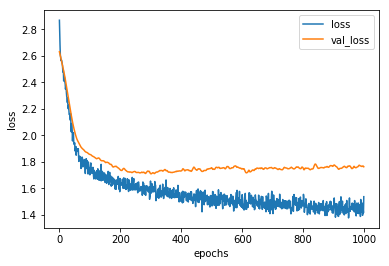

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

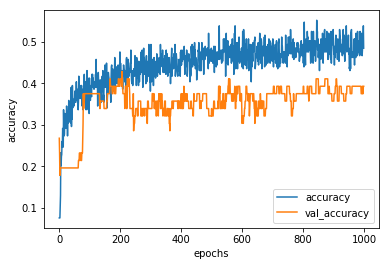

In [28]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

# TF 2.0
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

plt.legend(['accuracy', 'val_accuracy'])

In [29]:
model.predict([[X[0]]])

array([[9.78894386e-05, 1.08205553e-04, 2.70361576e-04, 8.18726271e-02,
        1.02920734e-04, 3.86499688e-02, 2.20555719e-03, 1.37578498e-03,
        1.55323360e-03, 2.53209961e-04, 1.29948379e-02, 9.63301025e-03,
        8.07070315e-01, 4.38120663e-02]], dtype=float32)

In [30]:
model.predict([[X[0]]]).argmax()

12

In [31]:
y[0]

12

In [32]:
y_pred = model.predict([X]).argmax(axis=1)
y_pred

array([12,  8, 12, 12, 12, 12, 11, 11, 11, 11, 12, 12,  8, 11, 11, 12, 12,
       11, 11,  2, 10, 10, 12,  8, 11,  8,  8, 10, 11,  8, 12,  8, 11,  8,
       11,  8, 12, 11, 11,  8,  8, 10, 12,  8, 11,  8,  8, 10, 10,  2, 12,
       13, 10, 13, 10, 12, 12,  8, 10, 10, 10, 10, 10, 10, 10, 10, 12, 11,
       11,  8, 11,  8,  8, 10, 10, 10, 10, 12, 11, 11,  8,  8, 10, 10, 12,
        8, 11, 11, 10, 10, 13, 10,  8,  8, 12, 13, 10, 10, 10, 12,  8, 10,
       12, 12,  8, 11, 12, 11, 11, 11, 10,  8, 10, 11, 12, 11,  8,  8, 10,
       10, 12, 11, 11,  8, 10, 10, 12, 11, 11,  8, 11, 10, 10, 11, 11, 11,
       10, 10, 11, 11,  8,  8, 10, 10, 12, 12, 12,  8, 10, 10, 10, 12, 12,
       10, 10, 10, 10, 10, 11, 11, 11,  8, 10, 10, 10, 12,  8, 12,  8, 11,
       10, 10, 10, 10, 10, 12, 12,  8, 12,  8, 11, 10, 12,  8, 11, 10, 12,
       12, 12,  8, 11, 11, 12, 12,  8, 11, 11, 12, 12,  8, 12,  8, 12, 12,
        8, 11,  8, 10, 11, 11,  8, 10, 12, 11,  8, 10, 12, 11, 11,  8,  8,
       10, 10, 10,  8, 10

In [33]:
y

array([12,  7,  3, 12,  3, 12, 11, 11, 12,  6, 12, 12,  8, 12,  7,  3, 12,
        8,  7,  2, 11, 10, 12,  9, 11,  8, 11, 11,  7, 10, 12, 11,  7, 11,
        8,  5, 12, 11,  7,  8,  8,  8, 12, 12,  7,  8, 11, 10,  7,  2, 13,
       13, 13, 13, 10,  5, 12, 10,  8, 10, 10, 10, 11, 10, 10,  6, 12, 11,
        7, 12,  7,  8,  8, 10, 11, 10,  6, 12, 11,  7,  8,  8, 10, 10, 12,
        7, 11,  2, 10, 13, 13, 11,  8,  8, 13, 13, 10,  5, 10, 12, 10, 11,
       12, 12,  8,  6, 12, 11, 11, 11,  8,  8, 12,  6, 12,  7,  8,  8,  5,
        6, 12, 11,  8,  8, 11,  6, 12, 11,  7, 11, 10, 10, 12, 11, 11, 10,
       10, 12, 11,  7,  8,  8, 11, 10, 12, 12, 12,  3, 10, 11, 10, 10,  3,
        3, 10, 10, 10, 12, 11, 11,  8,  8, 10, 11, 12, 12, 11, 12,  8, 11,
       11, 10, 10, 11, 11, 12, 12,  8, 11, 11, 11,  8, 12,  8, 11, 11, 12,
       12, 12,  8, 12,  6, 12, 12,  8, 12, 11,  5, 12,  8, 12,  8, 12, 12,
       12,  8, 11, 12, 11,  8,  8,  6, 12,  8,  8,  6, 12, 12, 12,  8,  8,
       10, 11,  7,  2, 11

In [34]:
# TF 2.0
cm = tf.math.confusion_matrix(labels=tf.constant(y, dtype=tf.int64), predictions=tf.constant(y_pred, dtype=tf.int64))
cm

<tf.Tensor: id=22121, shape=(14, 14), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  4,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  2, 12,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 34,  0,  8, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 34,  4,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0, 22, 27,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  8,  6, 46,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  2,  4]],
      dtype=int32)>

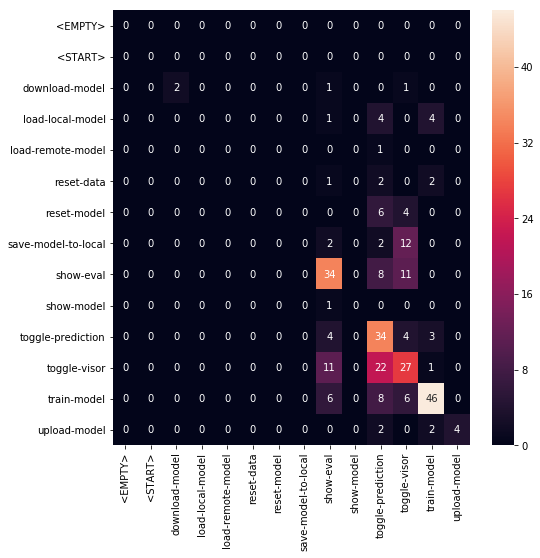

In [35]:
import seaborn as sns

classes = encoder.classes_

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes);

In [36]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(X)
embeddings_2d.shape

(279, 5, 2)

In [37]:
encoder.classes_

array(['<EMPTY>', '<START>', 'download-model', 'load-local-model',
       'load-remote-model', 'reset-data', 'reset-model',
       'save-model-to-local', 'show-eval', 'show-model',
       'toggle-prediction', 'toggle-visor', 'train-model', 'upload-model'],
      dtype='<U19')

In [0]:
encoded_classes = encoder.transform(encoder.classes_)

In [0]:
same_button_seqs = np.repeat(encoded_classes, 5).reshape(14, 5)

In [40]:
embeddings_2d = embedding_model.predict(same_button_seqs)
embeddings_2d.shape

(14, 5, 2)

In [41]:
only_first = embeddings_2d[:, 0, :]
only_first

array([[-0.00781773, -0.00638027],
       [-0.15964448,  0.05347453],
       [-0.04041966, -0.00026357],
       [-0.07364755,  0.0285954 ],
       [ 0.00276493, -0.0462673 ],
       [-0.10611954,  0.00841947],
       [-0.10117791,  0.21063556],
       [ 0.16280444, -0.10450128],
       [ 0.04665007, -0.17037311],
       [ 0.13859741,  0.22828631],
       [-0.10123737, -0.05630664],
       [ 0.08001171,  0.01762263],
       [ 0.13432185,  0.04202359],
       [-0.22794957, -0.2202854 ]], dtype=float32)

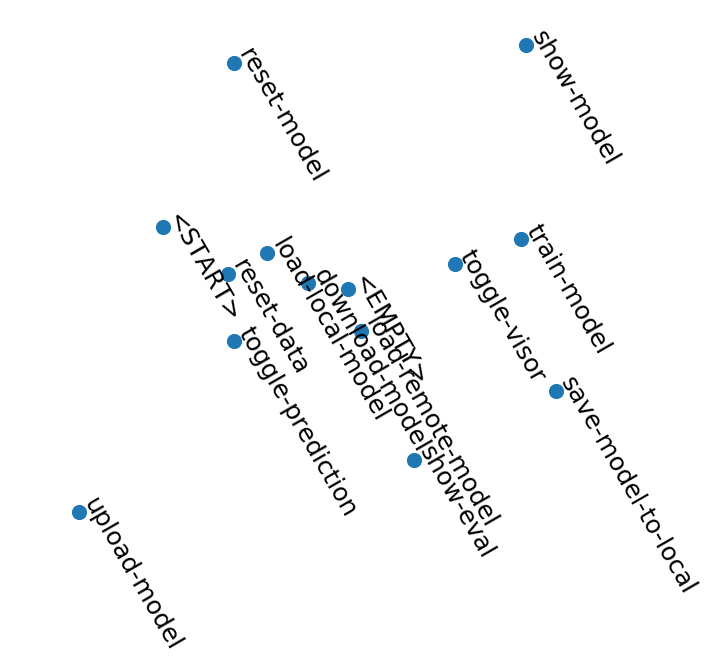

In [42]:
# for printing only
plt.figure(figsize=(10,10))
# plt.figure(dpi=600)
# plt.figure(dpi=300)

plt.axis('off')


plt.scatter(only_first[:, 0], only_first[:, 1], s=200)
for name, x_pos, y_pos in zip(encoder.classes_, only_first[:, 0], only_first[:, 1]):
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos),  rotation=-60, size=25)

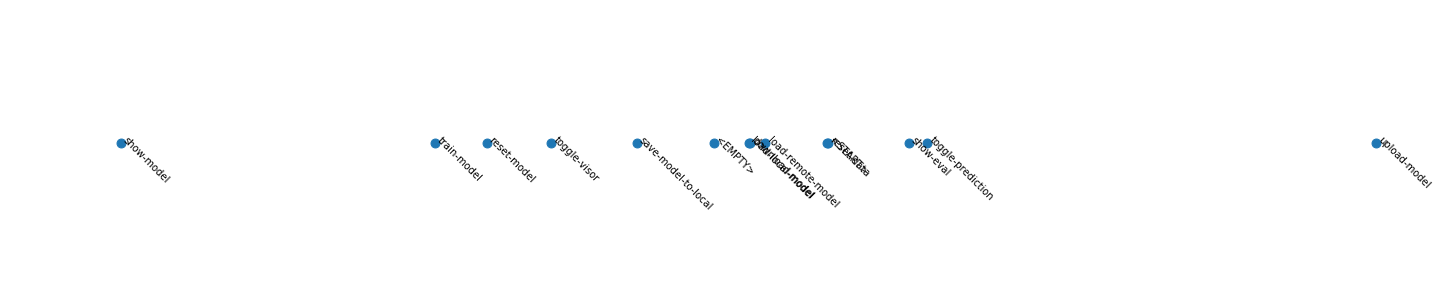

In [43]:
from sklearn.decomposition import PCA
import numpy as np

embeddings_1d = PCA(n_components=1).fit_transform(only_first)

# for printing only
plt.figure(figsize=(25,5))
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)), s=80)
for name, x_pos in zip(encoder.classes_, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=-45)

## Convert Model into tfjs format

* https://www.tensorflow.org/js/tutorials/conversion/import_keras

In [44]:
!pip install -q tensorflowjs

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 17.3MB 7.3MB/s 
     |████████████████████████████████| 81kB 22.5MB/s 
     |████████████████████████████████| 2.8MB 37.9MB/s 
     |████████████████████████████████| 109.2MB 337kB/s 
     |████████████████████████████████| 317kB 37.4MB/s 
     |████████████████████████████████| 256kB 45.0MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
     |████████████████████████████████| 655kB 43.4MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
model.save('ux.h5', save_format='h5')

In [46]:
!ls -l

total 88
drwxr-xr-x 1 root root  4096 Aug 27 16:17 sample_data
-rw-r--r-- 1 root root 82488 Sep 15 08:56 ux.h5


In [47]:
!tensorflowjs_converter --input_format keras ux.h5 tfjs

Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 6, in <module>
    from tensorflowjs.converters.converter import pip_main
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/__init__.py", line 24, in <module>
    from tensorflowjs.converters.tf_saved_model_conversion_v2 import convert_tf_saved_model
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/tf_saved_model_conversion_v2.py", line 36, in <module>
    import tensorflow_hub as hub
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_hub/__init__.py", line 29, in <module>
    from tensorflow_hub.estimator import LatestModuleExporter
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_hub/estimator.py", line 63, in <module>
    class LatestModuleExporter(tf_v1.estimator.Exporter):
AttributeError: module 'tensorf

In [48]:
!ls -l tfjs

ls: cannot access 'tfjs': No such file or directory


Download using _Files_ menu on the left